In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

!pip install scikit-optimize
!pip install fancyimpute
!pip install evaluation

import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from fancyimpute import IterativeImputer
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.1 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29898 sha256=117b538a5b64b12906d71357debd6c8245ecea278a2365abd0dfbd41725cfe60
  Stored in directory: /root/.cache/pip/wheels/f9/fc/6a/b0406b906bce293abe23c3b6da5a72637d2d04146ef1125a0b
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11352 sha256=99703dfc0557cce2ed8b872a4455b43e3db71fca3b887fb202ad907deaa7be8b
  Stored in directory: /root/.cache/pip/wheels/88/c4/be/e232c750d9bc360abf9a5e2cafe0d3e08e3605d2801bb11684
Successfully built fancyimpu

In [ ]:
from google.colab import files
file = files.upload()

Saving E Commerce Dataset 1.0.xlsx to E Commerce Dataset 1.0.xlsx


In [4]:
df = pd.read_excel("E Commerce Dataset 1.0.xlsx")

#Checking the data to identify types of variables and to check for missing values in the data
print(df.info())
print()
print()
print(df.describe())
print()
print()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [5]:
#dropping column "customerID" because it has no correlation or significance with the response variable
df.drop(['CustomerID'],axis=1, inplace=True)

# Find columns with missing values
cols_with_missing = df.columns[df.isnull().any()]

# Fill missing values with mean
for col in cols_with_missing:
    df[col].fillna(df[col].mean(), inplace=True)

#checking if missing values have been filled
print(df.isnull().sum())

Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64


In [6]:
fig2 = px.histogram(df, x='OrderAmountHikeFromlastYear', color="Complain")
fig2.show()

<Axes: xlabel='WarehouseToHome', ylabel='OrderAmountHikeFromlastYear'>

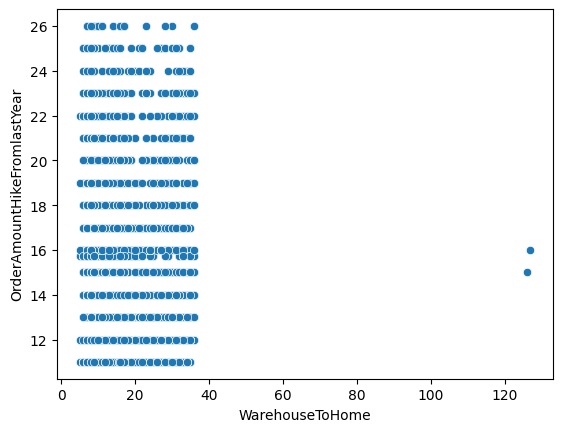

In [7]:
sns.scatterplot(data=df, x="WarehouseToHome", y="OrderAmountHikeFromlastYear")

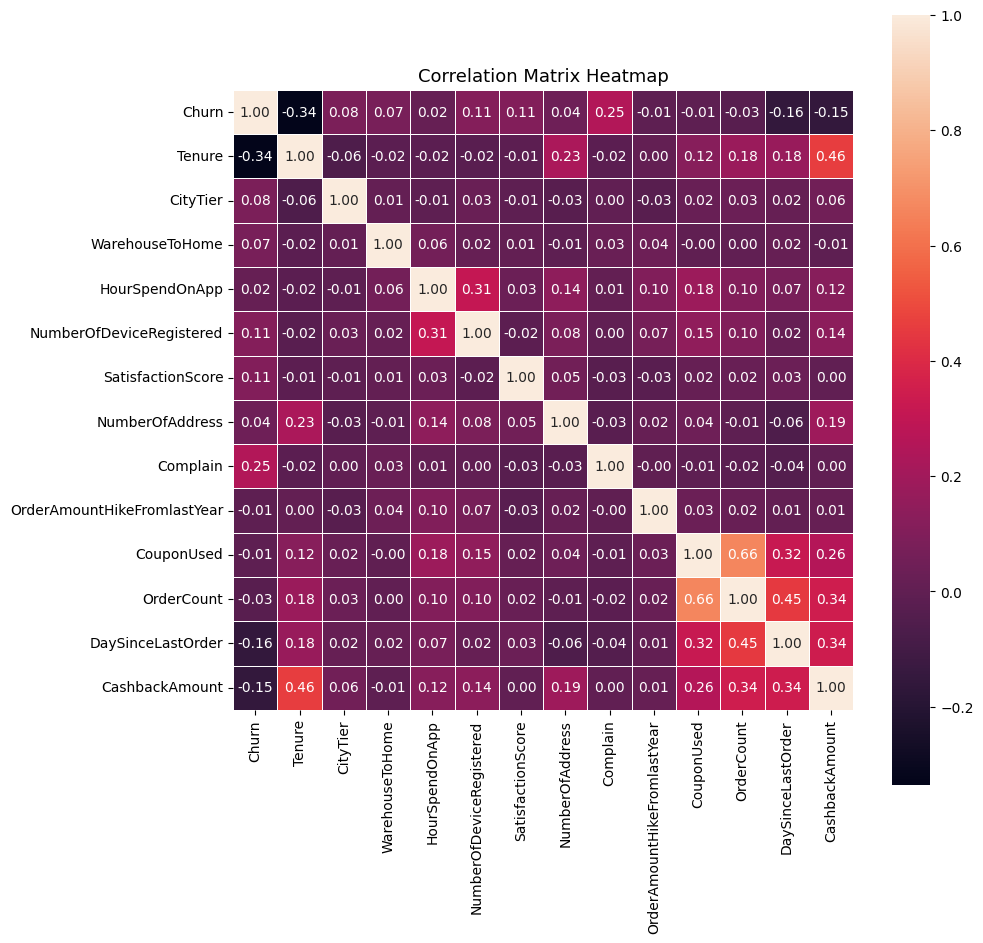

In [8]:
# calculating the correlation matrix
corr = df.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt=".2f", square=True, linewidth=.5)
plt.title('Correlation Matrix Heatmap', fontsize=13)
plt.show()

In [53]:
#Dropping OrderCount because of comparatively high correlation
df.drop(['OrderCount'],axis=1, inplace=True)

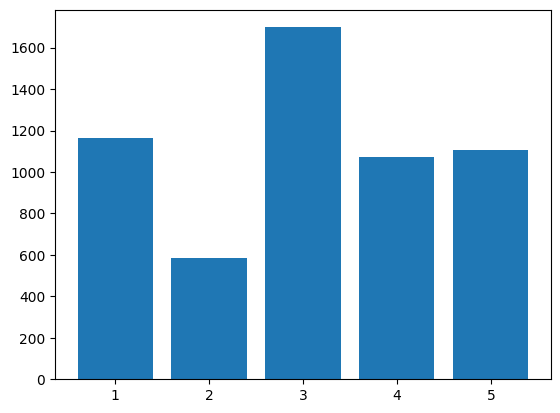

In [9]:
# creating a pandas series to store the value counts of SatisfactionScore
score_counts = df['SatisfactionScore'].value_counts()
plt.bar(score_counts.index, score_counts.values)
plt.show()

In [10]:
#converting the categorical variables to numerical variables using the one hot encoding method
df_categorical = df.select_dtypes(include='object')
print(df_categorical)
print()
print()
cat_numerical = pd.get_dummies(df_categorical,drop_first=True)

df_allnum = pd.concat([df.drop(df_categorical.columns, axis=1), cat_numerical], axis=1)

print(df_allnum.head())

     PreferredLoginDevice PreferredPaymentMode  Gender    PreferedOrderCat  \
0            Mobile Phone           Debit Card  Female  Laptop & Accessory   
1                   Phone                  UPI    Male              Mobile   
2                   Phone           Debit Card    Male              Mobile   
3                   Phone           Debit Card    Male  Laptop & Accessory   
4                   Phone                   CC    Male              Mobile   
...                   ...                  ...     ...                 ...   
5625             Computer          Credit Card    Male  Laptop & Accessory   
5626         Mobile Phone          Credit Card    Male             Fashion   
5627         Mobile Phone           Debit Card    Male  Laptop & Accessory   
5628             Computer          Credit Card    Male  Laptop & Accessory   
5629         Mobile Phone          Credit Card    Male  Laptop & Accessory   

     MaritalStatus  
0           Single  
1           Single  


In [11]:
#splitting the dataset into predictor and response variables. 
x=df_allnum.drop(['Churn'],axis=1)

print(x)
print()
print()
y=df_allnum['Churn']
print(y)

         Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
0      4.000000         3              6.0        3.000000   
1     10.189899         1              8.0        3.000000   
2     10.189899         1             30.0        2.000000   
3      0.000000         3             15.0        2.000000   
4      0.000000         1             12.0        2.931535   
...         ...       ...              ...             ...   
5625  10.000000         1             30.0        3.000000   
5626  13.000000         1             13.0        3.000000   
5627   1.000000         1             11.0        3.000000   
5628  23.000000         3              9.0        4.000000   
5629   8.000000         1             15.0        3.000000   

      NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  Complain  \
0                            3                  2                9         1   
1                            4                  3                7         1   
2              

In [12]:
#checking the proportion of the two classes of result variable-churn
resultclass_proportion = y.value_counts(normalize=True) * 100

print(resultclass_proportion)

0    83.161634
1    16.838366
Name: Churn, dtype: float64


In [52]:
#from the output we can see that the output classes are imbalance
#hence we are going to keept stratify=Y while splitting the dataset. 

#Splitting the predictor and response variables into training and test sets
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, stratify=y, random_state=52)


In [14]:
#Implementing logistic regression model
logistic_reg = Pipeline([('imputer',IterativeImputer(random_state=52)),('scaler',StandardScaler()), ('logreg',LogisticRegression())])

score for training dataset using Logistic Regression: 0.6112600536193029
score for test dataset using Logistic Regression: 0.6404958677685951


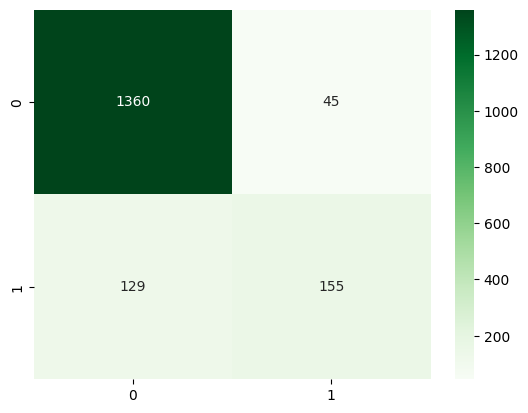

In [15]:

logistic_reg.fit(x_train,y_train)


print(f"score for training dataset using Logistic Regression: {f1_score(y_train, logistic_reg.predict(x_train))}")
print(f"score for test dataset using Logistic Regression: {f1_score(y_test, logistic_reg.predict(x_test))}")
logreg = confusion_matrix(y_test, logistic_reg.predict(x_test))
sns.heatmap(logreg, annot=True,fmt="g", cmap="Greens")
plt.show()

In [16]:
ytrain_logreg = logistic_reg.predict(x_train)
ytest_logreg = logistic_reg.predict(x_test)

In [17]:

print(classification_report(y_train, ytrain_logreg))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3277
           1       0.75      0.52      0.61       664

    accuracy                           0.89      3941
   macro avg       0.83      0.74      0.77      3941
weighted avg       0.88      0.89      0.88      3941



In [18]:

print(classification_report(y_test, ytest_logreg))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1405
           1       0.78      0.55      0.64       284

    accuracy                           0.90      1689
   macro avg       0.84      0.76      0.79      1689
weighted avg       0.89      0.90      0.89      1689



AUC: 0.894


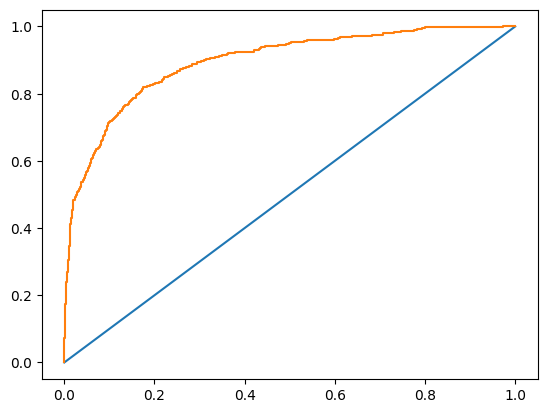

In [19]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# predict probabilities
p = logistic_reg.predict_proba(x_train)

# keeping probabilities for the positive outcome only
p = p[:, 1]

#  AUC
auc_lr = roc_auc_score(y_train, p)
print('AUC: %.3f' % auc_lr)

#  roc 
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, p)
plt.plot([0, 1], [0, 1], linestyle='-')

# plotting roc 
plt.plot(train_fpr, train_tpr)

AUC: 0.890


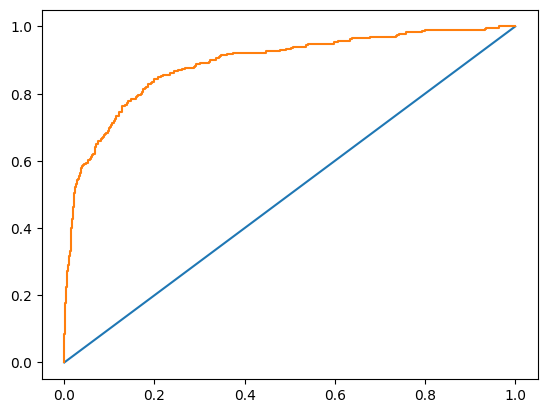

In [20]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# predict probabilities
p = logistic_reg.predict_proba(x_test)

# keeping probabilities for the positive outcome only
p = p[:, 1]
# AUC
auc_lr = roc_auc_score(y_test, p)
print('AUC: %.3f' % auc_lr)

# roc
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, p)
plt.plot([0, 1], [0, 1], linestyle='-')

# plotting roc
plt.plot(test_fpr, test_tpr)

In [21]:
#Implementing Xgboost
xgboost = Pipeline([('imputer',IterativeImputer(random_state=52)),('scaler',StandardScaler()),
                    ('xgb',XGBClassifier(verbosity=0,use_label_encoder=False))])

score for training dataset using XGBoost: 1.0
score for test dataset using XGBoost: 0.9051878354203936


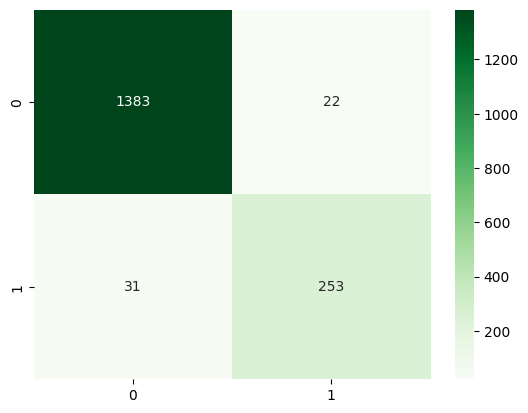

In [24]:

xgboost.fit(x_train,y_train)

print(f"score for training dataset using XGBoost: {f1_score(y_train, xgboost.predict(x_train))}")
print(f"score for test dataset using XGBoost: {f1_score(y_test, xgboost.predict(x_test))}")
xgb = confusion_matrix(y_test, xgboost.predict(x_test))
sns.heatmap(xgb, annot=True, fmt="g", cmap="Greens")
plt.show()

In [25]:
ytrain_xgb = xgboost.predict(x_train)
ytest_xgb = xgboost.predict(x_test)

In [26]:
print(classification_report(y_train, ytrain_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3277
           1       1.00      1.00      1.00       664

    accuracy                           1.00      3941
   macro avg       1.00      1.00      1.00      3941
weighted avg       1.00      1.00      1.00      3941



In [27]:
print(classification_report(y_test, ytest_xgb))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1405
           1       0.92      0.89      0.91       284

    accuracy                           0.97      1689
   macro avg       0.95      0.94      0.94      1689
weighted avg       0.97      0.97      0.97      1689



AUC: 1.000


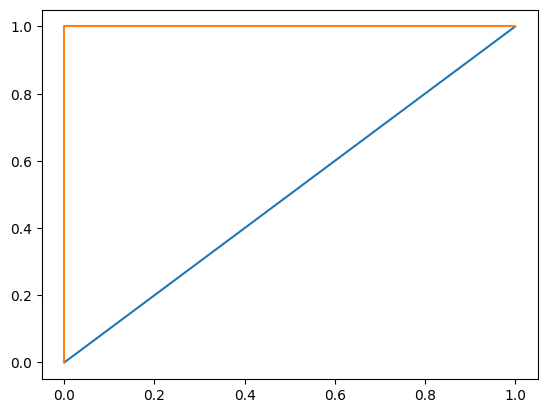

In [28]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# predict probabilities
p = xgboost.predict_proba(x_train)

# keepinging probabilities for the positive outcome only
p = p[:, 1]
# AUC
auc_xgb = roc_auc_score(y_train, p)
print('AUC: %.3f' % auc_xgb)

# roc
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, p)
plt.plot([0, 1], [0, 1], linestyle='-')
# plotting roc
plt.plot(train_fpr, train_tpr)

AUC: 0.986


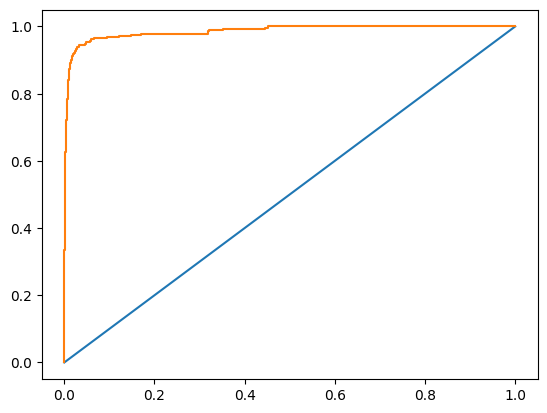

In [29]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# predict probabilities
p = xgboost.predict_proba(x_test)

# keep probabilities for the positive outcome only
p = p[:, 1]
# AUC
auc_xgb = roc_auc_score(y_test, p)
print('AUC: %.3f' % auc_xgb)

# roc 
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, p)
plt.plot([0, 1], [0, 1], linestyle='-')
# plotting roc 
plt.plot(test_fpr, test_tpr)

In [55]:
#Implementing Random forest
rf = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                        ('rfmodel',RandomForestClassifier())])

Test score for Random Forest: 0.8679245283018868
Training score for Random Forest: 1.0


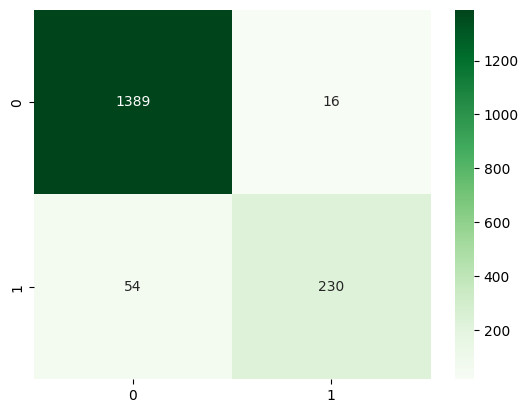

In [56]:

rf.fit(x_train,y_train)
print(f"Test score for Random Forest: {f1_score(y_test, rf.predict(x_test))}")
print(f"Training score for Random Forest: {f1_score(y_train, rf.predict(x_train))}")
matx = confusion_matrix(y_test, rf.predict(x_test))
sns.heatmap(matx, annot=True,fmt="g", cmap = 'Greens')
plt.show()

In [32]:
ytrain_rf = rf.predict(x_train)
ytest_rf = rf.predict(x_test)

In [33]:
print(classification_report(y_train, ytrain_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3277
           1       1.00      1.00      1.00       664

    accuracy                           1.00      3941
   macro avg       1.00      1.00      1.00      3941
weighted avg       1.00      1.00      1.00      3941



In [34]:
print(classification_report(y_test, ytest_rf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1405
           1       0.94      0.83      0.88       284

    accuracy                           0.96      1689
   macro avg       0.95      0.91      0.93      1689
weighted avg       0.96      0.96      0.96      1689



AUC: 0.987


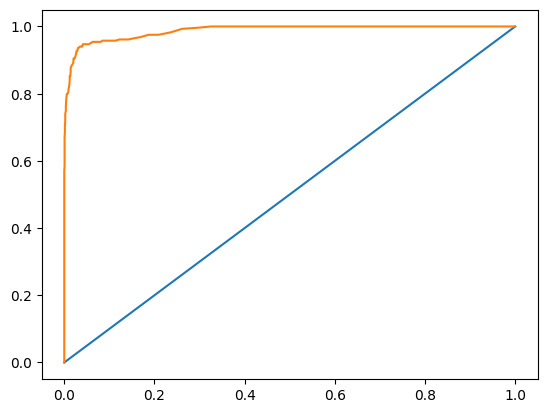

In [35]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# predict probabilities
p = rf.predict_proba(x_test)

# keeping probabilities for the positive outcome only
p = p[:, 1]
# AUC
auc_rf = roc_auc_score(y_test, p)
print('AUC: %.3f' % auc_rf)

# roc
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, p)
plt.plot([0, 1], [0, 1], linestyle='-')
# plot roc
plt.plot(test_fpr, test_tpr)

AUC: 1.000


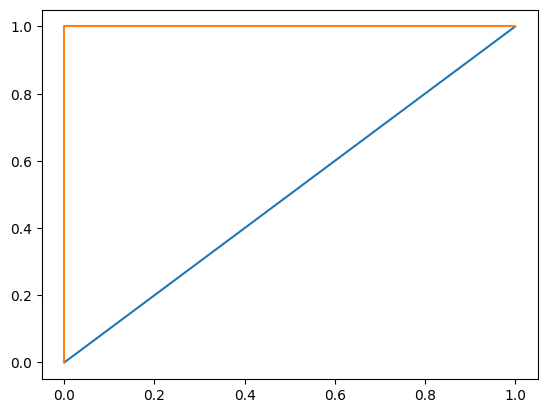

In [36]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# predict probabilities
p = rf.predict_proba(x_train)

# keeping probabilities for the positive outcome only
p = p[:, 1]
# AUC
auc_rf = roc_auc_score(y_train, p)
print('AUC: %.3f' % auc_rf)

#roc
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, p)
plt.plot([0, 1], [0, 1], linestyle='-')
# plot roc
plt.plot(train_fpr, train_tpr)

In [37]:
#Implementing Decsion Tree
from sklearn import tree
dt_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                        ('rfmodel', tree.DecisionTreeClassifier())])

Test score for Decision Tree: 0.8392554991539762
Training score for Decision Tree: 1.0


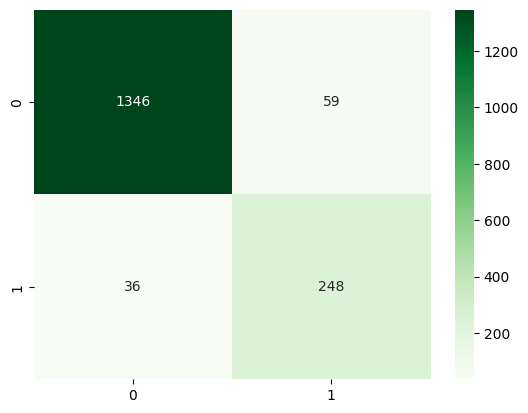

In [38]:

dt_pipe.fit(x_train,y_train)
print(f"Test score for Decision Tree: {f1_score(y_test, dt_pipe.predict(x_test))}")
print(f"Training score for Decision Tree: {f1_score(y_train, dt_pipe.predict(x_train))}")
dt_mat = confusion_matrix(y_test, dt_pipe.predict(x_test))
sns.heatmap(dt_mat, annot=True,fmt="g", cmap = 'Greens')
plt.show()

In [39]:
ytrain_dt = dt_pipe.predict(x_train)
ytest_dt = dt_pipe.predict(x_test)

In [40]:
print(classification_report(y_train, ytrain_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3277
           1       1.00      1.00      1.00       664

    accuracy                           1.00      3941
   macro avg       1.00      1.00      1.00      3941
weighted avg       1.00      1.00      1.00      3941



In [41]:
print(classification_report(y_test, ytest_dt))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1405
           1       0.81      0.87      0.84       284

    accuracy                           0.94      1689
   macro avg       0.89      0.92      0.90      1689
weighted avg       0.95      0.94      0.94      1689



AUC: 0.916


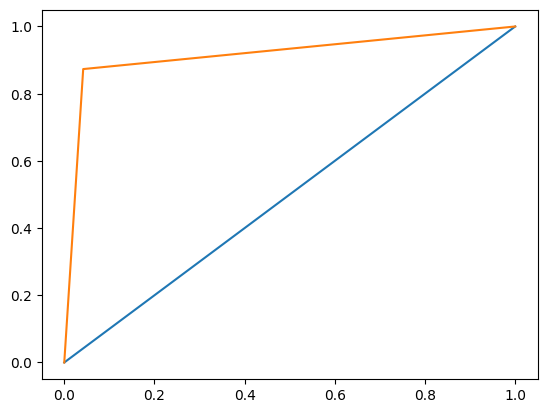

In [42]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# predict probabilities
p = dt_pipe.predict_proba(x_test)

# keeping probabilities for the positive outcome only
p = p[:, 1]
# AUC
auc_dt = roc_auc_score(y_test, p)
print('AUC: %.3f' % auc_dt)

# roc 
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, p)
plt.plot([0, 1], [0, 1], linestyle='-')
# plot roc 
plt.plot(test_fpr, test_tpr)

AUC: 1.000


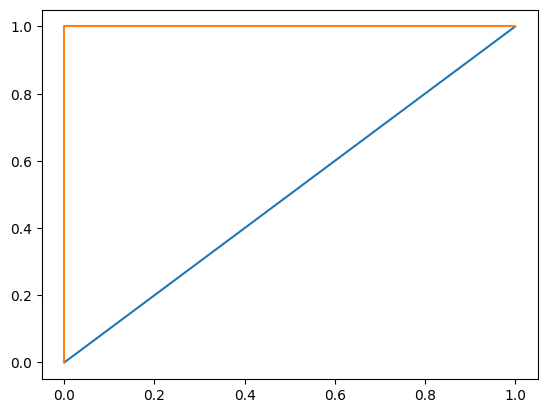

In [57]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# predicting the probabilities
p = dt_pipe.predict_proba(x_train)

# keeping probabilities for the positive outcome only
p = p[:, 1]
# AUC
auc_dt = roc_auc_score(y_train, p)
print('AUC: %.3f' % auc_dt)

# roc
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, p)
plt.plot([0, 1], [0, 1], linestyle='-')
# plot roc
plt.plot(train_fpr, train_tpr)